In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
from gpytorch import means, kernels, lazy
import tqdm
from PIL import Image
%load_ext line_profiler

base_dir = os.path.join(os.getcwd(), '../..')
sys.path.append(base_dir)

from src.models import VariationalCMEProcess
from src.likelihoods import CMEProcessLikelihood

standardize = lambda x: (x - x.mean()) / x.std()

### Load low and high resolutions images

HR shape : (135, 135) | (15.0, 15.0) bags
LR shape : (15, 15) | 225 bags


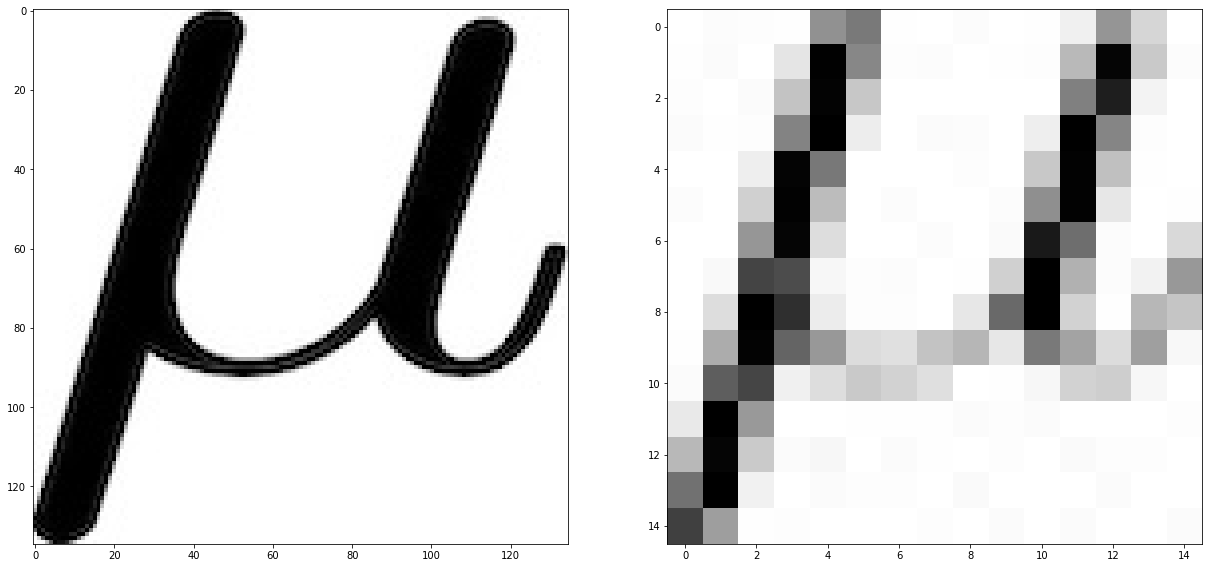

In [2]:
mu_hr = Image.open('./data/mu_hr.jpg')
mu_hr = np.array(mu_hr)[..., 0]
mu_lr = Image.open('./data/mu_lr.jpg')
mu_lr = np.array(mu_lr)[..., 0]

mu_hr, mu_lr = standardize(mu_hr), standardize(mu_lr)
n_bags = mu_lr.shape[0] * mu_lr.shape[1]
    
print(f"HR shape : {mu_hr.shape} | {(mu_hr.shape[0] / 9, mu_hr.shape[1] / 9)} bags")
print(f"LR shape : {mu_lr.shape} | {n_bags} bags")

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[0].imshow(mu_hr, cmap='gray')
ax[1].imshow(mu_lr, cmap='gray')

plt.tight_layout()
plt.show()

### Create dataset

In [3]:
# Create training grid
x1 = torch.arange(0, mu_hr.shape[0])
x2 = torch.arange(0, mu_hr.shape[1])
grid = torch.stack(torch.meshgrid(x1, x2), dim=-1).float()
grid = (grid - grid.mean()) / grid.std()

def make_grid_dataset(grid, block_size):
    blocks = torch.cat([torch.stack(x.split(block_size, dim=1)) 
                        for x in grid.split(block_size)]).view(-1, block_size**2, 2)
    bags = blocks.mean(dim=1)
    extended_bags = bags.unsqueeze(1).repeat((1, block_size**2, 1))
    return blocks, bags, extended_bags

individuals_tensors, bags_tensor, extended_bags_tensor = make_grid_dataset(grid, 9)
aggregate_targets_tensor = torch.from_numpy(mu_lr.flatten()).float()
inducing_points = grid[4::9, 4::9].reshape(-1, 2)

print("Individuals : ", individuals_tensors.shape)
print("Bags values : ", bags_tensor.shape)
print("Aggregate targets : ", aggregate_targets_tensor.shape)
print("Extended bags values : ", extended_bags_tensor.shape)
print("Inducing points : ", inducing_points.shape)

def batch_iterator(batch_size):
    rdm_indices = torch.randperm(n_bags)
    for idx in rdm_indices.split(batch_size):
        x = individuals_tensors[idx].reshape(-1, 2)
        y = bags_tensor[idx]
        extended_y = extended_bags_tensor[idx].reshape(-1, 2)
        z = aggregate_targets_tensor[idx]
        yield x, y, extended_y, z

Individuals :  torch.Size([225, 81, 2])
Bags values :  torch.Size([225, 2])
Aggregate targets :  torch.Size([225])
Extended bags values :  torch.Size([225, 81, 2])
Inducing points :  torch.Size([225, 2])


### Define covariance modules

In [4]:
# Define mean and covariance modules
individuals_mean = means.ZeroMean()

base_individuals_kernel = kernels.ScaleKernel(kernels.MaternKernel(nu=1.5, ard_num_dims=2))
base_individuals_kernel.base_kernel.initialize(raw_lengthscale=-1.6 * torch.ones(2))

bag_kernel = kernels.ScaleKernel(kernels.MaternKernel(nu=1.5, ard_num_dims=2))
bag_kernel.base_kernel.initialize(raw_lengthscale=-1.6 * torch.ones(2))

kernel_grid = [grid[:, 0, 0], grid[0, :, 1]]
individuals_kernel = kernels.GridKernel(base_kernel=base_individuals_kernel,
                                        grid=kernel_grid)

# Permute everything to match grid kernel legacy
individuals_tensors = individuals_tensors[:, :, torch.tensor([1, 0])]
bags_tensor = bags_tensor[:, torch.tensor([1, 0])]
extended_bags_tensor = extended_bags_tensor[:, :, torch.tensor([1, 0])]
inducing_points = inducing_points[:, torch.tensor([1, 0])]

### Create model

In [5]:
# Instantiate model
model = VariationalCMEProcess(inducing_points=inducing_points,
                              individuals_mean=individuals_mean, 
                              individuals_kernel=individuals_kernel,
                              bag_kernel=bag_kernel,
                              lbda=0.01)

likelihood = CMEProcessLikelihood()

### Fit MLE of hyperparameters

In [7]:
torch.random.manual_seed(52)
epochs = 10
batch_size = 16

model.train()
likelihood.train()

parameters = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params=parameters, lr=3e-4)

elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(aggregate_targets_tensor))

epochs_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")
for epoch in epochs_iter:
    batch_iter = tqdm.notebook.tqdm(batch_iterator(batch_size), desc="Batch", 
                                    total=len(bags_tensor) // batch_size)
    for x, y, extended_y, z in batch_iter:
        optimizer.zero_grad()
        q = model(x)
        buffer = model.get_elbo_computation_parameters(bags_values=y,
                                                       extended_bags_values=extended_y)
        root_inv_extended_bags_covar, bags_to_extended_bags_covar = buffer
        loss = -elbo(variational_dist_f=q, 
                     target=z,
                     root_inv_extended_bags_covar=root_inv_extended_bags_covar,
                     bags_to_extended_bags_covar=bags_to_extended_bags_covar)

        loss.backward()
        optimizer.step()
        lengthscales = model.individuals_kernel.base_kernel.base_kernel.lengthscale[0].detach()
        batch_iter.set_postfix(loss=loss.item(),
                               n=likelihood.noise.item(),
                               l1=lengthscales[0].item(),
                               l2=lengthscales[1].item())

### Visualize prediction

In [8]:
model.eval()
likelihood.eval()

x_test = grid.reshape(-1, 2)[:, torch.tensor([1, 0])]

with torch.no_grad():
    individuals_posterior = model(x_test)

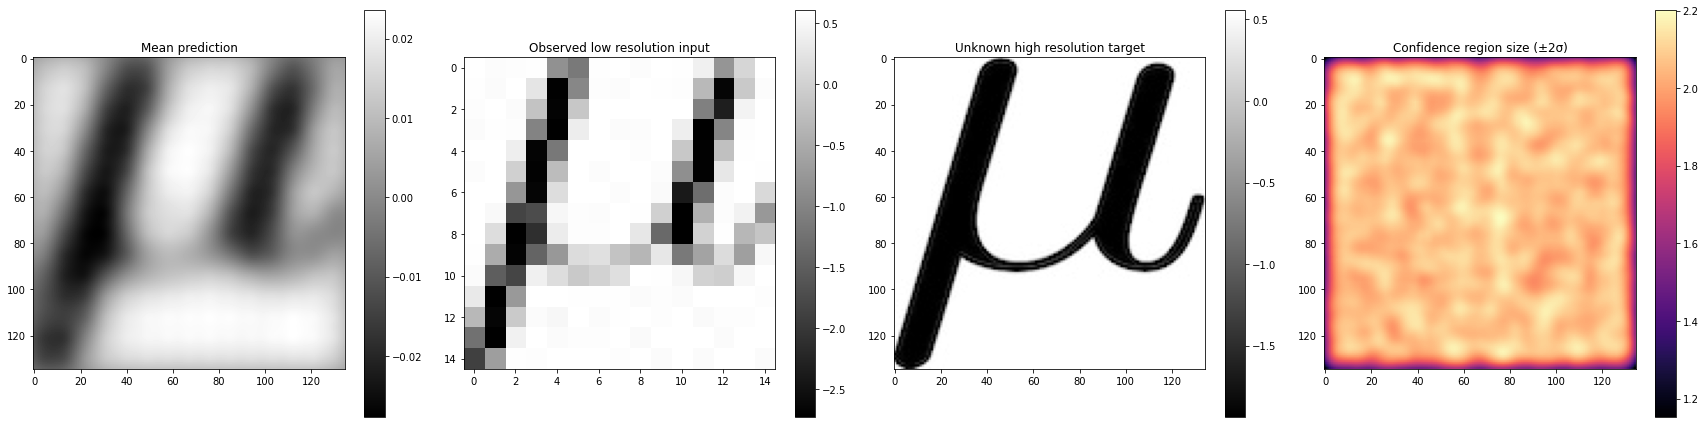

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6))

predictive_mean = individuals_posterior.mean.reshape(*grid.shape[:-1])
confidence_region = individuals_posterior.confidence_region()
confidence_region_size = confidence_region[1] - confidence_region[0]

im0 = ax[0].imshow(predictive_mean.reshape(*grid.shape[:-1]), cmap='gray')
im1 = ax[1].imshow(mu_lr, cmap='gray')
im2 = ax[2].imshow(mu_hr, cmap='gray')
im3 = ax[3].imshow(confidence_region_size.reshape(*grid.shape[:-1]), cmap='magma')

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])

ax[0].set_title("Mean prediction")
ax[1].set_title("Observed low resolution input")
ax[2].set_title("Unknown high resolution target")
ax[3].set_title("Confidence region size (±2σ)")

plt.tight_layout()
plt.show()